In [2]:
using JuMP, Gurobi, Random

In [1]:
using JuMP, Gurobi, StatsBase, DataFrames, CSV, LinearAlgebra, Distributions, Random, Plots
const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2022-09-11


Gurobi.Env(Ptr{Nothing} @0x00007fe9044aba00, false, 0)

In [2]:
#using Dualization

In [3]:
function l2_regression(X, y, rho; solver_output=0)
    n,p = size(X)
    
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", solver_output) 
    set_optimizer_attribute(model, "NonConvex", 2) 
    
    @variable(model,beta[j=1:p])
    @variable(model, sse>=0)
    #@variable(model, reg>=0)
    @constraint(model, sum((y[i]-sum(X[i,j]*beta[j] for j=1:p))^2 for i=1:n) <= sse)
    #@constraint(model, sum(beta[j]^2 for j=1:p)<=reg)
    @objective(model,Min, 1/n*sse + rho*sum(beta[j]^2 for j=1:p))
    
    optimize!(model)
    #println("Obj ", objective_value(model))
    return value.(beta)
end

l2_regression (generic function with 1 method)

In [6]:
function solve_model(m)
    optimize!(m)
    U_OA = objective_value(m)
    #println("U_OA from solve ", U_OA)
    return value.(m[:y]), U_OA
end

solve_model (generic function with 1 method)

In [7]:
function solve_model_benders(m)
    "Solve the Benders master problem
    "
    optimize!(m)
    U_OA = objective_value(m)
    #println("U_OA from solve ", U_OA)
    return value.(m[:β]), value.(m[:α]), U_OA
end

solve_model_benders (generic function with 1 method)

In [8]:
function get_Y(X, t)
    "
    Create the vector of data for the dual problem
    "
    T, p = size(X)
    Y = zeros(1,T*p)
    Y[(t-1)*p+1:t*p] = X[t,:]
    return Y
end

function get_Z(X)
    T, p = size(X)
    Z = zeros(T, T*p)
    for t=1:T
        Z[t,:] = get_Y(X,t)
    end
    return Z
end

function get_A(X, t)
    T, p = size(X)
    A = zeros(p,T*p)
    A[:,(t-1)*p+1:t*p] = 1 * Matrix(I, p, p)
    return A
end

get_A (generic function with 1 method)

In [9]:
function S_primal(X, y, β0, epsilon, delta)
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus[i=1:n],  - y[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus[i=1:n],  y[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return objective_value(model), getvalue.(β)
end

S_primal (generic function with 1 method)

In [10]:
function master_primal(X0, Xt, y0, Dmin, Dmax, epsilon, delta, reg, ρ)
    
    M = 1000
    n0, p = size(X0)
    n, _ = size(Xt)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 
    @variable(model, β0[j=1:p])
    @variable(model, z[i=1:n], Bin)
    @variable(model, y[i=1:n])
    # Add objective
    @objective(model, Min, 1/n0*sum((y0[i]-sum(X0[i,j]*β0[j] for j=1:p))^2 for i=1:n0) 
        + reg*sum(b[i] for i=1:n) + ρ*sum(β0[j]^2 for j=1:p))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus_min[i=1:n],  - y[i] + dot(Xt[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus_min[i=1:n],  y[i] - dot(Xt[i,:],β[i,:]) <= b[i])
    
    @constraint(model,  y .== Dmax.*z + Dmin.*(1 .-z))
    #@constraint(model,  y .== Dmax.*(1 .-z) + Dmin.*z)
    
    #@constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:])-Dmin[i])^2 + M*z[i] >= (dot(Xt[i,:],β[i,:])-Dmax[i])^2)
    @constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:]) - Dmin[i])^2 - (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*z[i] >= 0)


    #@constraint(model, bigM2[i=1:n],  (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*(1-z[i]) >= (dot(Xt[i,:],β[i,:])-Dmin[i])^2)

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    println("SUM ", sum(getvalue.(b)))
    println("Y ", getvalue.(y))
    return objective_value(model), getvalue.(β), getvalue.(β0)
end

master_primal (generic function with 1 method)

In [11]:
function master_primal_l2(X0, Xt, y0, Dmin, Dmax, epsilon, delta, reg, ρ, ϵ_l2, δ_l2, β0_fix = false, β0_val = 0)
    
    M = 1000
    n0, p = size(X0)
    n, _ = size(Xt)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 
    @variable(model, β0[j=1:p])
    @variable(model, z[i=1:n], Bin)
    @variable(model, y[i=1:n])
    # Add objective
    @objective(model, Min, 1/n0*sum((y0[i]-sum(X0[i,j]*β0[j] for j=1:p))^2 for i=1:n0) 
        + reg*sum(b[i] for i=1:n) + ρ*sum(β0[j]^2 for j=1:p))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    if β0_fix
        @constraint(model, β0 .== β0_val)
    end
    @constraint(model, res_plus_min[i=1:n],  - y[i] + dot(Xt[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus_min[i=1:n],  y[i] - dot(Xt[i,:],β[i,:]) <= b[i])
    
    @constraint(model,  y .== Dmax.*z + Dmin.*(1 .-z))
    #@constraint(model,  y .== Dmax.*(1 .-z) + Dmin.*z)
    
    #@constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:])-Dmin[i])^2 + M*z[i] >= (dot(Xt[i,:],β[i,:])-Dmax[i])^2)
    @constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:]) - Dmin[i])^2 - (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*z[i] >= 0)


    #@constraint(model, bigM2[i=1:n],  (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*(1-z[i]) >= (dot(Xt[i,:],β[i,:])-Dmin[i])^2)

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    @constraint(model, sq_0[i=1:n], sum((β[i,:] .- β0).^2) .<= ϵ_l2)
    @constraint(model, sq_t[i=2:n], sum((β[i,:] .- β[i-1,:]).^2) .<= δ_l2)
    
    #@constraint(model, abs_0[i=1:n], sum(abs.(β[i,:] .- β0)) .<= ϵ_l1)
    #@constraint(model, abs_t[i=2:n], sum(abs.(β[i,:] .- β[i-1,:])) .<= δ_l1)
    
    optimize!(model);
    #println("SUM ", sum(getvalue.(b)))
    #println("Y ", getvalue.(y))
    return objective_value(model), getvalue.(β), getvalue.(β0)
end

master_primal_l2 (generic function with 3 methods)

In [12]:
function master_primal_l2_ridge(X0, Xt, y0, Dmin, Dmax, epsilon, delta, reg, ρ, ϵ_l2, δ_l2, β0_fix = false, β0_val = 0)
    
    M = 1000
    n0, p = size(X0)
    n, _ = size(Xt)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, β0[j=1:p])
    @variable(model, z[i=1:n], Bin)
    @variable(model, y[i=1:n])
    # Add objective
    @objective(model, Min, 1/n0*sum((y0[i]-sum(X0[i,j]*β0[j] for j=1:p))^2 for i=1:n0) 
        + reg*sum((y[i] - dot(Xt[i,:],β[i,:]))^2 for i=1:n) + ρ*sum(β0[j]^2 for j=1:p))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    if β0_fix
        @constraint(model, β0 .== β0_val)
    end
    
    @constraint(model,  y .== Dmax.*z + Dmin.*(1 .-z))
    #@constraint(model,  y .== Dmax.*(1 .-z) + Dmin.*z)
    
    #@constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:])-Dmin[i])^2 + M*z[i] >= (dot(Xt[i,:],β[i,:])-Dmax[i])^2)
    @constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:]) - Dmin[i])^2 - (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*z[i] >= 0)


    #@constraint(model, bigM2[i=1:n],  (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*(1-z[i]) >= (dot(Xt[i,:],β[i,:])-Dmin[i])^2)

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    @constraint(model, sq_0[i=1:n], sum((β[i,:] .- β0).^2) .<= ϵ_l2)
    @constraint(model, sq_t[i=2:n], sum((β[i,:] .- β[i-1,:]).^2) .<= δ_l2)
    
    #@constraint(model, abs_0[i=1:n], sum(abs.(β[i,:] .- β0)) .<= ϵ_l1)
    #@constraint(model, abs_t[i=2:n], sum(abs.(β[i,:] .- β[i-1,:])) .<= δ_l1)
    
    optimize!(model);
    #println("SUM ", sum(getvalue.(b)))
    #println("Y ", getvalue.(y))
    return objective_value(model), getvalue.(β), getvalue.(β0)
end

master_primal_l2_ridge (generic function with 3 methods)

In [13]:
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 300, 400, 50, 0., false)
obj, βt_val_p, β0_val_p = master_primal(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, 1)
obj

LoadError: UndefVarError: prepare_data_from_y not defined

In [13]:
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 300, 400, 10, 0.1, false)
obj, βt_val_p, β0_val_p = master_primal(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ)
obj

LoadError: UndefVarError: prepare_data_from_y not defined

In [14]:
#X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 300, 400, 5, 0.1, false)
obj, βt_val_p, β0_val_p = master_primal(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ)
obj

LoadError: UndefVarError: X0 not defined

In [15]:
#X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data(X, y, 300, 400, 2, 0.1)
#X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, 100, 20, 0.01, false)

obj, β0_val, α_val, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, ρ, 30, false)
obj
println(y_val)

LoadError: UndefVarError: master_problem not defined

In [17]:
_, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta)

LoadError: UndefVarError: Xt not defined

In [18]:
println("ALPHA ", α_val)
println("\n BETA ", β0_val)
println("\nBETA T ", βt_val[1,:])

LoadError: UndefVarError: α_val not defined

In [19]:
objp, βt_valp, β0_valp = master_primal(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ)
objp

LoadError: UndefVarError: X0 not defined

In [14]:
function S_dual(X, y, β0, epsilon, delta)
    
    #Dual problem
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return objective_value(model), getvalue.(λ), getvalue.(ν), getvalue.(μ)
end

S_dual (generic function with 1 method)

In [15]:
function R(X, D_min, D_max, β0, epsilon, delta) 
    "
    Full dual problem
    "
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
       
    # Add objective
    @objective(model, Max, 2*dot(λ[1,:],y) - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T)) #
    optimize!(model)
    return objective_value(model), getvalue.(y), getvalue.(λ), getvalue.(ν), getvalue.(μ)
end

R (generic function with 1 method)

In [131]:
l2_regression(X0, y0, 0.5)

10-element Vector{Float64}:
 66.41702382259751
 11.104049275802806
  4.640036502994368
  8.277029989501468
  2.927990672708151
  3.140601983800178
 20.58843430250832
 10.008009151329002
  9.271487148034973
  9.386633251093418

In [180]:
function master_problem(X0, Xt, y0, D_min, D_max, threshold = 0.1, epsilon = 0.1, delta = 0.1, reg = 1, ρ = 1, max_cuts = 10, verbose=0)
    n, p = size(X0)
    T, p = size(Xt)
    #Z = get_Z(X0)
    L_BD = -10000
    U_BD = 10000
    cuts = 0
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, α)
    @variable(model, β[j=1:p])
    
    #Warm start for β

    #β_val0 = l2_regression(X0, y0, ρ)#Random.rand(p)#   
    β_val0 = Random.rand(p)
    
    
    #Initialization
    _, y_val0, λ_val0, ν_val0, μ_val0 = R(Xt, D_min, D_max, β_val0, epsilon, delta)
    
    #First constraint
    @constraint(model, α >= 2*dot(λ_val0[1,:],y_val0) - sum(y_val0)
                            - delta * sum(sum(ν_val0[1,t,i]+ν_val0[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val0[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val0[2,t,:]) for t = 1:T))
       
    # Add objective
    @objective(model, Min, 1/n*sum((y0[i]-sum(X0[i,j]*β[j] for j=1:p))^2 for i=1:n) + reg*α + ρ*sum(β[j]^2 for j=1:p))
    
    while cuts < max_cuts && U_BD - L_BD > threshold
        if verbose
            println("Lower: ", L_BD, " Upper: ", U_BD)
        end
        cuts += 1
        
        #Solve current Master Problem
        β_val, α_val, L_BD = solve_model_benders(model)
        U_OA, y_val, λ_val, ν_val, μ_val = R(Xt, D_min, D_max, β_val, epsilon, delta)
        
        U_BD = 1/n*sum((y0[i]-sum(X0[i,j]*β_val[j] for j=1:p))^2 for i=1:n) + reg*U_OA + ρ*sum(β_val[j]^2 for j=1:p)
        
        if U_BD - L_BD > threshold
            @constraint(model, α >= 2*dot(λ_val[1,:],y_val) - sum(y_val)
                            - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val[2,t,:]) for t = 1:T))
            if verbose                    
                println("Cut added")
                println("y_val: ", y_val)
            end
        end
    end
    optimize!(model)
    β_val, α_val, L_BD = solve_model_benders(model)
    U_OA, y_val, λ_val, ν_val, μ_val = R(Xt, D_min, D_max, β_val, epsilon, delta)
    if verbose
        println("Final model Obj value: ", objective_value(model))
        println("Lower: ", L_BD, " Upper: ", U_BD)
        println("Final y: ", y_val)
    end
    return objective_value(model), getvalue.(β), getvalue.(α), y_val#, getvalue.(ν), getvalue.(μ)
end    

master_problem (generic function with 8 methods)

In [17]:
function compute_CVaR(errs, α_risk)
#     '''
#     Compute the Conditional Value at Risk
#     :param X: Either the data matrix X or the errors
#     :param y: the target values
#     :param alpha: the risk value
#     :param beta:
#     :param b0:
#     :param errs: whether you want to input the data matrix X or the errors
#     :return: the model and the CVaR
#     '''
    n = size(errs)[1]
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, τ) 
    @variable(model, z[1:n] >= 0) 

    # Add objective
    @objective(model, Min, sum(z)/(α_risk * n) + τ)

    @constraint(model, [1:n], errs .- τ .<= z)

    optimize!(model)

    return objective_value(model)
end

compute_CVaR (generic function with 1 method)

In [18]:
X_test_adaptive = CSV.read("traffic_predictions_test_val.csv", DataFrame)
select!(X_test_adaptive, Not([:DummyRegressor,:Lasso, :LassoLars]))#, index = 'Unnamed: 0')
y_test = CSV.read("traffic_test_val_scaled.csv", DataFrame)#, index = 'Unnamed: 0')
n0 = 1000
n = 100
m = 1
X = X_test_adaptive[!,1:25]
X = X[!,[2, 3,5,8,9,11,12,13,25]]
y = y_test[!, "target"];
X0 = Matrix(X[n0:n0+n,:])
X0[:,1] = ones(n+1)
y0 = y[n0:n0+n,:][:]

yt_true = y[n0+n+1:n0+n+m,:][:]
Xt = Matrix(X[n0+n+1:n0+n+m,:])
Xt[:,1] = ones(m)
yt = mean(Xt, dims = 2)#y[n0+n+1:n0+n+m,:][:]
epsilon = 0.01
delta = 0.01
threshold = 1e-8
reg = 1;

#X_test_adaptive = X_test_adaptive.drop(columns = ['DummyRegressor', 'Lasso', 'LassoLars'])

In [9]:
##### SAFI #####

X_test_adaptive = CSV.read("data/X_test_adaptive.csv", DataFrame)
y_test = CSV.read("data/y_test_speed.csv", DataFrame)
# select!(X_test_adaptive, Not([:RANSACRegressor, :GaussianProcessRegressor, :KernelRidge, :Lars, :AdaBoostRegressor,
#                      :DummyRegressor, :ExtraTreeRegressor, :Lasso, :LassoLars, :PassiveAggressiveRegressor]))
n0 = 1000
n = 100
m = 1
X = X_test_adaptive#[!,1]
#X = X[!,[2, 3,5,8,9,11,12,13,25]]
y = y_test[!, "speed"];
X0 = Matrix(X[n0:n0+n,:])
X0[:,1] = ones(n+1)
y0 = y[n0:n0+n,:][:]

yt_true = y[n0+n+1:n0+n+m,:][:]
Xt = Matrix(X[n0+n+1:n0+n+m,:])
Xt[:,1] = ones(m)
yt = mean(Xt, dims = 2)#y[n0+n+1:n0+n+m,:][:]
epsilon = 0.01
delta = 0.01
threshold = 1e-8
reg = 1;

In [10]:
X

,Column1,NUMTECH_speed,speed,DT_speed,TABNET_speed,RIDGE_speed,LASSO_speed
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,8.35541,6.0887,6.19167,6.17883,6.62696,6.52294
2,1,8.13818,6.15938,6.19167,6.14982,6.65407,6.49015
3,2,7.5746,5.97212,5.7355,5.95013,6.14063,6.07155
4,3,7.35083,5.75858,6.37407,6.11738,5.91941,5.86016
5,4,7.02436,5.45474,5.43617,5.61699,5.67112,5.70789
6,5,6.43641,5.37782,5.43617,5.20299,5.36965,5.49662
7,6,6.4,4.7982,5.43617,4.87613,5.18333,5.38626
8,7,5.4,5.02718,5.29886,4.74052,5.32947,5.32619
9,8,4.7,4.80789,5.29886,4.73528,5.08329,5.08518


In [11]:
##### TRAFFIC #####
X_test_adaptive = CSV.read("data/traffic_X_past4_future1.csv", DataFrame)
y_test = CSV.read("data/traffic_y_past4_future1.csv", DataFrame)
# select!(X_test_adaptive, Not([:RANSACRegressor, :GaussianProcessRegressor, :KernelRidge, :Lars, :AdaBoostRegressor,
#                      :DummyRegressor, :ExtraTreeRegressor, :Lasso, :LassoLars, :PassiveAggressiveRegressor]))
n0 = 1000
n = 100
m = 1
X = Matrix(X_test_adaptive)
X = (X .- mean(X[1:20000,:], dims =1))./ std(X[1:20000,:], dims=1)#[!,1]
acc = zeros(size(X,2)-16)
t = 1
for i = 1:size(X,2)
    me = mean(eachcol(X'))
    if (me[i]>-1000000)
        acc[t] = floor(i)
        t+=1
    end
end

X = X[:,round.(Int, acc)]
#X = X[!,[2, 3,5,8,9,11,12,13,25]]
y = y_test[:, 1];
y = (y .- mean(y[1:20000,:], dims =1))./ std(y[1:20000,:], dims=1)
X0 = Matrix(X[n0:n0+n,:])
X0[:,1] = ones(n+1)
y0 = y[n0:n0+n,1]

yt_true = y[n0+n+1:n0+n+m]
Xt = Matrix(X[n0+n+1:n0+n+m,:])
Xt[:,1] = ones(m)
yt = mean(Xt, dims = 2)#y[n0+n+1:n0+n+m,:][:]
epsilon = 0.01
delta = 0.01
threshold = 1e-8
reg = 1;

In [25]:
X_test_adaptive = CSV.read("data/traffic_predictions_test_val.csv", DataFrame)
X = X_test_adaptive[!,[2, 3,5,8,9,11,12,13,25]]
y_test = CSV.read("data/traffic_test_val_scaled.csv", DataFrame);

In [4]:
##### ENERGY #####
X_test_adaptive = CSV.read("data/energy_predictions_test_val.csv", DataFrame)
y_test = CSV.read("data/energy_y_test_val.csv", DataFrame, header = 0)
# select!(X_test_adaptive, Not([:RANSACRegressor, :GaussianProcessRegressor, :KernelRidge, :Lars, :AdaBoostRegressor,
#                      :DummyRegressor, :ExtraTreeRegressor, :Lasso, :LassoLars, :PassiveAggressiveRegressor]))

X = Matrix(X_test_adaptive)[:,2:10]
#X[:,1] = ones(n)
n, p = size(X)

X = (X .- mean(X[1:floor(Int, n/2),:], dims =1))./ std(X[1:floor(Int, n/2),:], dims=1)#[!,1]
#X[:,1] = ones(n)

y = y_test[:, 1];
y = (y .- mean(y[1:floor(Int, n/2),:], dims =1))./ std(y[1:floor(Int, n/2),:], dims=1);

In [30]:
y_test[:,2]

24099-element Vector{Float64}:
 -0.8410568216121944
 -0.37437748375906915
  0.20301407998899976
  0.5396189641000838
  0.696502656399645
  0.6299760273865399
  0.6528135268985014
  0.6160749407270851
  0.5515341812367593
  0.5892657021695652
  0.38124586965843804
  0.3152157080260278
  0.10372060385003691
  ⋮
  0.5515341812367593
  0.5515341812367593
  0.5128097255425638
  0.5128097255425638
  0.5033768453093623
  0.4284102708244454
  0.33656380539590475
  0.13599098359519984
 -0.24231716049424856
 -0.551119871286423
 -0.9031152441990462
 -1.1493630650236741

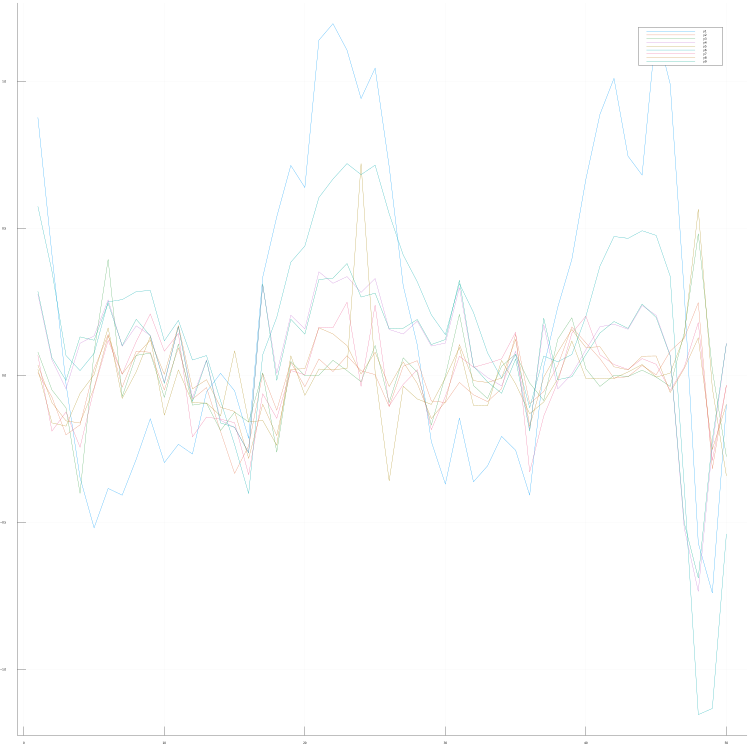

In [31]:
plot(Matrix(X)[1:50,:].-y_test[1:50,2])
plot!(size=(3000,3000))

In [30]:
for i = 1:8
    if mean(abs.(X[!,i].-y)) < 3
        println(i)
        println(mean(abs.(X[!,i].-y)))
    end
end

LoadError: ArgumentError: invalid index: ! of type typeof(!)

In [31]:
X[!,[3,5,8,9,11,12,13,25]]

LoadError: ArgumentError: invalid index: ! of type typeof(!)

In [36]:
function prepare_data_from_X(X, y, n0, n, m, std_factor)
    
    X0 = Matrix(X[n0:n0+n,:])
    X0[:,1] = ones(n+1)
    y0 = y[n0:n0+n,:][:]

    yt_true = y[n0+n+1:n0+n+m,:][:]
    Xt = Matrix(X[n0+n+1:n0+n+m,:])
    Xt[:,1] = ones(m)
    yt = mean(Xt, dims = 2)
    
    D_min = yt .- std_factor*std(Xt, dims = 2)
    D_max = yt .+ std_factor*std(Xt, dims = 2)
    
    return X0, y0, Xt, yt, yt_true, D_min, D_max
end

prepare_data_from_X (generic function with 1 method)

In [37]:
function prepare_data_from_y(X, y, n0, n, m, uncertainty, last_yT = false)
    
    X0 = Matrix(X[n0:n0+n,:])
    X0[:,1] = ones(n+1)
    y0 = y[n0:n0+n,:][:]

    yt_true = y[n0+n+1:n0+n+m,:][:]
    Xt = Matrix(X[n0+n+1:n0+n+m,:])
    Xt[:,1] = ones(m)
    yt = yt_true
    if last_yT
        yt_true[m] = mean(Xt[m])
    end
    
    D_min = yt .- uncertainty.*abs.(yt)
    D_max = yt .+ uncertainty.*abs.(yt)
    
    return X0, y0, Xt, yt, yt_true, D_min, D_max
end

prepare_data_from_y (generic function with 2 methods)

In [38]:
function build_beta(X, y, n0, n, m, std_factor, steps)
    p = size(X)[2]
    β_list = zeros(steps, p)
    for s=1:steps
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data(X, y, n0+s, n, m, std_factor)
        obj, β, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)
        β_list[s,:] = β
    end
    return β_list
end

build_beta (generic function with 1 method)

In [39]:
function eval(X, y, split, epsilon, delta, past, reg = 1, max_cuts = 10, verbose = false, last_yT = true)
    n, p = size(X)
    split_index = floor(Int,n*split)
    val = 50#n-split_index
    β_list = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-4*past, 3*past, past-1, 0.001, last_yT)
        obj, β0_val, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, max_cuts, verbose)
        _, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta);
        #println("Beta.     ", size(Xt))
        β_list[s,:] = βt_val[past-1,:]
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, 0.001, last_yT)
    println("MAE :", mean(abs(yt_true[s]-dot(Xt[s,:],β_list[s,:])) for s=1:val))
    return β_list
end

eval (generic function with 6 methods)

In [240]:
split_ = 0.5
past = 6
num_past = 50
last_yT = false
max_cuts = 20
verbose = false
uncertainty = 0.01#1
epsilon = 0.01
ϵ_l2 = 0.01
δ_l2 = 0.01

ϵ_l1 = 0.01
δ_l1 = 0.01

delta = 0.01
reg = 1/(past*num_past)
ρ = 0.01
val = 100; #n-split_index;

In [241]:
#RECENT DATA BEST SO FAR
n,p = size(X)
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2 = l2_regression(X0,y0,ρ);

println("Primal L2 Beta0 Adaptive")
if true
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past-1, uncertainty, last_yT)
        obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ, ϵ_l2, δ_l2)
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val]
        
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))

end

Primal L2 Beta0 Adaptive

### β0 Baseline ###
MAE Baseline: 0.27489903571821034
CVAR 0.05 :1.5659459887258644
CVAR 0.15 :0.9138294143947536

### β0 Adaptive ###
MAE 0: 0.2835084880844912
CVAR 0.05 :1.5401535644276423
CVAR 0.15 :0.9046790539742986

### βt Adaptive ###
MAE t: 0.2671454193213749
CVAR 0.05 :1.6223805539578473
CVAR 0.15 :0.9077611225836285


In [242]:
#RECENT DATA + last t true
n,p = size(X)
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2 = l2_regression(X0,y0,ρ);

#println("MAE BASELINE:", mean(err_baseline)
#println("Primal L2 Beta0 Adaptive")
if true
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past, uncertainty, true)
        obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ, ϵ_l2, δ_l2)
        β_listt[s,:] = βt_val[past,:]
        β_list0[s,:] = β0_val
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val]
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
    
end


### β0 Baseline ###
MAE Baseline: 0.27489903571821034
CVAR 0.05 :1.5659459887258644
CVAR 0.15 :0.9138294143947536

### β0 Adaptive ###
MAE 0: 0.2860457705842487
CVAR 0.05 :1.5549014345265237
CVAR 0.15 :0.9106208096840195

### βt Adaptive ###
MAE t: 0.28438261881030336
CVAR 0.05 :1.5345803338391417
CVAR 0.15 :0.9164983543414758


In [243]:
#RECENT DATA
n,p = size(X)
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2 = l2_regression(X0,y0,ρ);

println("Primal L2 Beta0 Ridge BOTH + Adaptive")
if true
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past-1, uncertainty, last_yT)
        obj, βt_val, β0_val = master_primal_l2_ridge(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ, ϵ_l2, δ_l2)
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
        
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val]
        
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
end

Primal L2 Beta0 Ridge BOTH + Adaptive

### β0 Baseline ###
MAE Baseline: 0.27489903571821034
CVAR 0.05 :1.5659459887258644
CVAR 0.15 :0.9138294143947536

### β0 Adaptive ###
MAE 0: 0.28850660484153606
CVAR 0.05 :1.5176578975294361
CVAR 0.15 :0.9006549048769752

### βt Adaptive ###
MAE t: 0.27045677807047513
CVAR 0.05 :1.5911772372493256
CVAR 0.15 :0.9000604023559079


In [244]:
#RECENT DATA
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2_init = l2_regression(X0,y0,ρ);

println("Primal L2 Beta0 Adaptive More data for beta0")
if true
    n, p = size(X)
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    β_listl2 = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        #Difference is here
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, s+(num_past-1)*past, past-1, uncertainty, last_yT)
        obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ, ϵ_l2, δ_l2)
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
        β_l2 = l2_regression(X0,y0,ρ);
        β_listl2[s,:] = β_l2
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_l2 = [abs(yt_true[s]-dot(Xt[s,:],β_listl2[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2_init)) for s=1:val]
        
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    
    println("\n### β0 Baseline Retrained ###")
    println("MAE Baseline: ", mean(err_l2))
    println("CVAR 0.05 :", compute_CVaR(err_l2, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_l2, 0.15))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
end

Primal L2 Beta0 Adaptive More data for beta0

### β0 Baseline ###
MAE Baseline: 0.27489903571821034
CVAR 0.05 :1.5659459887258644
CVAR 0.15 :0.9138294143947536

### β0 Baseline Retrained ###
MAE Baseline: 0.2790867223931563
CVAR 0.05 :1.5591803660895087
CVAR 0.15 :0.906301801042346

### β0 Adaptive ###
MAE 0: 0.27060636095236745
CVAR 0.05 :1.5577723169023079
CVAR 0.15 :0.900779431203802

### βt Adaptive ###
MAE t: 0.2542301192363638
CVAR 0.05 :1.6342318050967768
CVAR 0.15 :0.9033286293025746


In [ ]:
#RECENT DATA CHEAT E
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2 = l2_regression(X0,y0,ρ);

println("MAE BASELINE:", mean(abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val))
println("Primal L2 Beta0 Adaptive More data for beta0")
if true
    n, p = size(X)
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        #Difference is here
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, s+(num_past-1)*past, past, uncertainty, last_yT)
        obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ, ϵ_l2, δ_l2)
        β_listt[s,:] = βt_val[past,:]
        β_list0[s,:] = β0_val
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    println("MAE t: ", mean(abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val))
    println("MAE 0: ", mean(abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val))
end

In [64]:
println("Primal L2 Beta0 NOT Adaptive")
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2 = l2_regression(X0,y0,ρ);
if true
    n, p = size(X)
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)
    β_l2 = l2_regression(X0,y0,ρ);
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past-1, uncertainty, last_yT)
        obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, ρ, ϵ_l2, δ_l2, true, β_l2)
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val]
        
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
end

Primal L2 Beta0 NOT Adaptive


LoadError: Result index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.

In [65]:
println("RETRAINING L2 REG")
if true
    n, p = size(X)
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
        
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, s+(num_past-1)*past, past-1, uncertainty, last_yT)
        β_l2 = l2_regression(X0,y0,ρ);
        β_list0[s,:] = β_l2
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)

    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]

    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
end

RETRAINING L2 REG

### β0 Baseline ###
MAE Baseline: 29.0289397922627
CVAR 0.05 :174.08618812698063
CVAR 0.15 :98.41460088861754


In [246]:
split_ = 0.5
past = 6
num_past = 500
last_yT = false
max_cuts = 10
verbose = false
uncertainty = 0.02#1#1#1
epsilon = 0.03
ϵ_l2 = 0.01
δ_l2 = 0.01

ϵ_l1 = 0.01
δ_l1 = 0.01

delta = 0.03
reg = 1/(past*num_past)*10
ρ = 1
val = 500; #n-split_index;

In [266]:
##### ENERGY #####
X_test_adaptive = CSV.read("data/energy_predictions_test_val.csv", DataFrame)
y_test = CSV.read("data/energy_y_test_val.csv", DataFrame, header = 0)
# select!(X_test_adaptive, Not([:RANSACRegressor, :GaussianProcessRegressor, :KernelRidge, :Lars, :AdaBoostRegressor,
#                      :DummyRegressor, :ExtraTreeRegressor, :Lasso, :LassoLars, :PassiveAggressiveRegressor]))

X = Matrix(X_test_adaptive)[:,10:15]
#X[:,1] = ones(n)
n, p = size(X)

X = (X .- mean(X[1:floor(Int, n/2),:], dims =1))./ std(X[1:floor(Int, n/2),:], dims=1)#[!,1]
#X[:,1] = ones(n)

y = y_test[:, 1];
y = (y .- mean(y[1:floor(Int, n/2),:], dims =1))./ std(y[1:floor(Int, n/2),:], dims=1);

In [268]:
n/2

4932.5

In [269]:
split_ = 0.5
past = 6
num_past = 500
last_yT = false
max_cuts = 20
verbose = false
uncertainty = 0.01#1
epsilon = 0.01
ϵ_l2 = 0.01
δ_l2 = 0.01

ϵ_l1 = 0.01
δ_l1 = 0.01

delta = 0.01
reg = 1/(past*num_past)
ρ = 0.01
val = 4000; #n-split_index;

In [270]:
println("BENDERS MIN MAX")
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2_init = l2_regression(X0,y0,ρ);
if true
    n, p = size(X)
    split_index = floor(Int,n*split_)
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    β_listl2 = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past-1, uncertainty, last_yT)
        obj, β0_val, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, ρ, max_cuts, verbose)
        _, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta);
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
        β_l2 = l2_regression(X0,y0,ρ);
        β_listl2[s,:] = β_l2
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, 0.001, last_yT)
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2_init)) for s=1:val]
    err_l2 = [abs(yt_true[s]-dot(Xt[s,:],β_listl2[s,:])) for s=1:val]
        
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    println("R2 : ", R2_err(err_baseline, yt_true))
    
    println("\n### β0 Baseline Retrained ###")
    println("MAE Baseline: ", mean(err_l2))
    println("CVAR 0.05 :", compute_CVaR(err_l2, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_l2, 0.15))
    println("R2 : ", R2_err(err_l2, yt_true))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))
    println("R2 : ", R2_err(err_0, yt_true))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
    println("R2 : ", R2_err(err_t, yt_true))
end

BENDERS MIN MAX

### β0 Baseline ###
MAE Baseline: 0.2627352751314888
CVAR 0.05 :1.9473312269697098
CVAR 0.15 :0.9822820676258044
R2 : 0.5266415745652266

### β0 Baseline Retrained ###
MAE Baseline: 0.24290494826447925
CVAR 0.05 :1.9512844536431047
CVAR 0.15 :0.9648245267564151
R2 : 0.5343177916135115

### β0 Adaptive ###
MAE 0: 0.24254993496097896
CVAR 0.05 :1.9517792611295062
CVAR 0.15 :0.9646473413219652
R2 : 0.5344148579302592

### βt Adaptive ###
MAE t: 0.24223783134302987
CVAR 0.05 :1.9787495785754592
CVAR 0.15 :0.9715847209108726
R2 : 0.5285974969811842


In [79]:
function R2(y_true, y_test)
    SSR = sum(abs2.(y_true.-y_test))
    SST = sum(abs2.(y_true.-mean(y_true)))
    return 1 - SSR/SST
end

function R2_err(err, y_true)
    SSR = sum(abs2.(err))
    SST = sum(abs2.(y_true.-mean(y_true)))
    return 1 - SSR/SST
end

R2_err (generic function with 1 method)

In [86]:
y_test_ = [dot(Xt[s,:],β_listt[s,:]) for s=1:val]
R2_err(err_t, yt_true)
R2_err(err_0, yt_true)
println("R2 : ", R2_err(err_t, yt_true))

R2 : 0.6910062532128638
R2 : 0.6910062532128638


In [299]:
split_ = 0.5
past = 6
num_past = 50

last_yT = false
max_cuts = 20
verbose = false

uncertainty = 0.#1
δ_inf = 0.01
ϵ_inf = 0.01

ϵ_l2 = 0.5
δ_l2 = 0.5

reg = 1/(past*num_past)
ρ = 0.01
val = 1000; #n-split_index;

X = Matrix(X_test_adaptive)[:,10:15]
#X[:,1] = ones(n)
n, p = size(X)

X = (X .- mean(X[1:floor(Int, n/2),:], dims =1))./ std(X[1:floor(Int, n/2),:], dims=1)#[!,1]
#X[:,1] = ones(n)

y = y_test[:, 1];
y = (y .- mean(y[1:floor(Int, n/2),:], dims =1))./ std(y[1:floor(Int, n/2),:], dims=1);

fix_β0 = false
more_data_for_β0 = false
benders = false
ridge = false

eval_method(X, y, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT, 
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose, 
        fix_β0, more_data_for_β0, benders, ridge)

ridge = true
eval_method(X, y, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT, 
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose, 
        fix_β0, more_data_for_β0, benders, ridge)


### β0 Baseline ###
MAE Baseline: 0.3185360613522453
CVAR 0.05 :1.8762257584892872
CVAR 0.15 :1.0572474215525478
R2 : 0.5538433226795101

### β0 Baseline Retrained ###
MAE Baseline: 0.24657783357473842
CVAR 0.05 :1.9699865904347758
CVAR 0.15 :0.9734413903950367
R2 : 0.5909458601070536

### β0 Adaptive ###
MAE 0: 0.24377622931146917
CVAR 0.05 :1.9741889920624258
CVAR 0.15 :0.9720291279101865
R2 : 0.5919379826653168

### βt Adaptive ###
MAE t: 0.2436585065768307
CVAR 0.05 :1.9933310599606822
CVAR 0.15 :0.9764846119558457
R2 : 0.5913043502061865

### β0 Baseline ###
MAE Baseline: 0.3185360613522453
CVAR 0.05 :1.8762257584892872
CVAR 0.15 :1.0572474215525478
R2 : 0.5538433226795101

### β0 Baseline Retrained ###
MAE Baseline: 0.24657783357473842
CVAR 0.05 :1.9699865904347758
CVAR 0.15 :0.9734413903950367
R2 : 0.5909458601070536

### β0 Adaptive ###
MAE 0: 0.2455476515515215
CVAR 0.05 :1.9851679775537607
CVAR 0.15 :0.9753471875010354
R2 : 0.5908159164642738

### βt Adaptive ###
MAE t: 0.24

In [297]:
function eval_method(X, y, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT, 
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose, 
        fix_β0, more_data_for_β0, benders, ridge)
    
    
    n, p = size(X)
    split_index = floor(Int,n*split_)
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    β_listl2 = zeros(val, p)
    β_l2_init = l2_regression(X0,y0,ρ);
    for s=1:val
        
        if more_data_for_β0
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, s+(num_past-1)*past, past-1, uncertainty, last_yT)
        else
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past-1, uncertainty, last_yT)
        end
        
        
        if benders
            ##TODO handle fix_beta0
            obj, β0_val, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, ϵ_inf, δ_inf, reg, ρ, max_cuts, verbose)
            _, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta);
        else
            if ridge
                obj, βt_val, β0_val = master_primal_l2_ridge(X0, Xt, y0, D_min, D_max, ϵ_inf, δ_inf, reg, ρ, ϵ_l2, δ_l2, fix_β0, β_l2_init)
            else
                obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, ϵ_inf, δ_inf, reg, ρ, ϵ_l2, δ_l2, fix_β0, β_l2_init)
            end
        end
        
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
        β_l2 = l2_regression(X0,y0,ρ);
        β_listl2[s,:] = β_l2
    
    end
    
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2_init)) for s=1:val]
    err_l2 = [abs(yt_true[s]-dot(Xt[s,:],β_listl2[s,:])) for s=1:val]
        
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    println("R2 : ", R2_err(err_baseline, yt_true))
    
    println("\n### β0 Baseline Retrained ###")
    println("MAE Baseline: ", mean(err_l2))
    println("CVAR 0.05 :", compute_CVaR(err_l2, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_l2, 0.15))
    println("R2 : ", R2_err(err_l2, yt_true))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))
    println("R2 : ", R2_err(err_0, yt_true))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
    println("R2 : ", R2_err(err_t, yt_true))
end

eval_method (generic function with 3 methods)

In [219]:
println("BENDERS MIN MAX MORE DATA")
n, p = size(X)
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2_init = l2_regression(X0,y0,ρ);
if true
    
    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    β_listl2 = zeros(val, p)
    for s=1:val #n-split_index #s+split_index-past
        X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, s+(num_past-1)*past, past-1, uncertainty, last_yT)
        obj, β0_val, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, ρ, max_cuts, verbose)
        _, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta);
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
        β_l2 = l2_regression(X0,y0,ρ);
        β_listl2[s,:] = β_l2
    end
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, 0.001, last_yT)
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2_init)) for s=1:val]
    err_l2 = [abs(yt_true[s]-dot(Xt[s,:],β_listl2[s,:])) for s=1:val]
        
    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    
    println("\n### β0 Baseline Retrained ###")
    println("MAE Baseline: ", mean(err_l2))
    println("CVAR 0.05 :", compute_CVaR(err_l2, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_l2, 0.15))
    
    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
end

BENDERS MIN MAX MORE DATA


LoadError: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

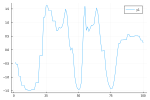

In [314]:
using Plots
plot(yt)

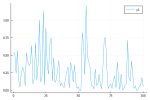

In [315]:
plot(err_t)

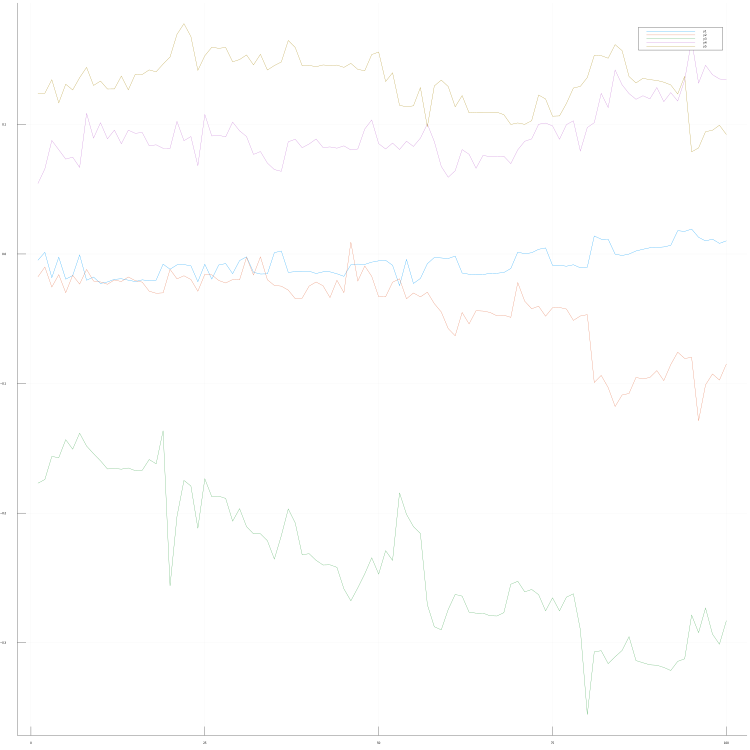

In [36]:
using Plots
plot(β_listt[1:100,1:5])
plot!(size=(3000,3000))

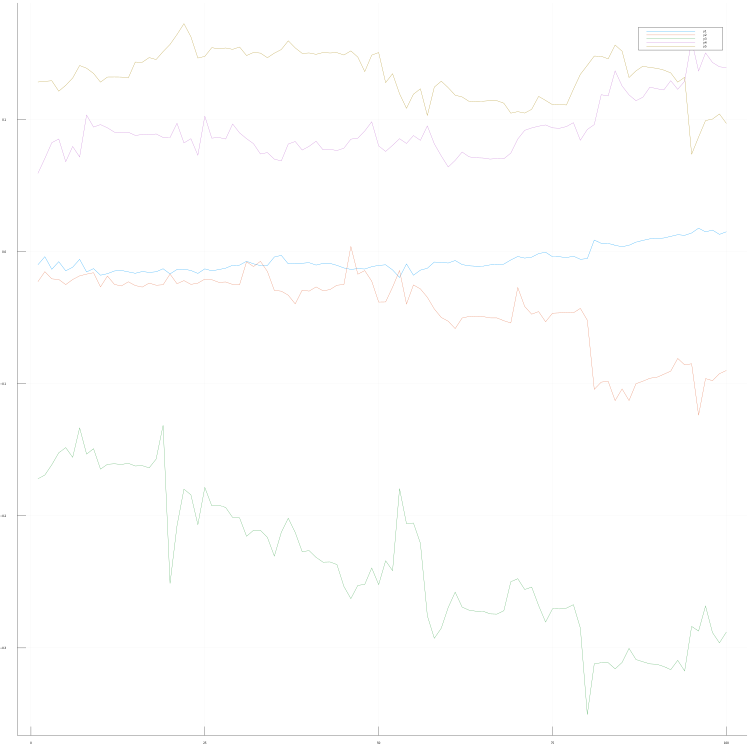

In [37]:
plot(β_list0[1:100,1:5])
plot!(size=(3000,3000))

In [38]:
#COMPLETE DATA
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, 0.001, last_yT)

β_l2 = l2_regression(X0,y0,ρ);
println("MAE :", mean(abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val))


#RECENT DATA
split_index = floor(Int,n*split_)
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

β_l2 = l2_regression(X0,y0,ρ);

println("MAE :", mean(abs(yt_true[s]-dot(Xt[s,:],β_l2)) for s=1:val))
#println(yt_true[1:5])

MAE :0.10428774253536056
MAE :0.11498805163879784


In [39]:
β_list = eval(X, y, 0.8, 0.05, 0.05, 3, 1, 10, false, false);

MAE :0.309742539069418


In [40]:
n,p=size(X)
val = 1000
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, 1, floor(Int,n*0.8), val, 0.001, false)
println("MAE :", mean(abs(yt_true[s]-dot(Xt[s,:],β_list[s,:])) for s=1:val))

LoadError: BoundsError: attempt to access 50×25 Matrix{Float64} at index [51, 1:25]

In [41]:
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data(X, y, 300, 400, 2, 0.)
obj, β0_val, _, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, 0.1, 1, 20, true)

LoadError: UndefVarError: prepare_data not defined

In [42]:
X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_X(X, y, 300, 400, 1, 0.)
obj, βt_val, β0_val = master_primal(X0, Xt, y0, D_min, D_max, epsilon, delta, reg, 1)

SUM 0.05891714743187168
Y [-0.44386344070283895]


(0.08817602063789642, [-0.014685787327139353 0.026060312800598822 … 0.014437640412758256 0.055170207329806445], [-0.01968578726405236, 0.021060314019407035, 0.06085136421722453, 0.03744343132607663, 0.05767276948108224, 0.011010122460632637, 0.03709268335914622, 0.05933494659064286, 0.061105180885810705, 0.01943763982354174  …  0.03730831535077282, 0.037267803841185616, 0.03688511564642888, 0.04075728208110737, 0.03727573700959144, 0.03724666684930604, 0.03775954792198467, 0.03756678302761834, 0.019437639823541873, 0.06017020721870124])

In [43]:
obj, βt_val = S_primal(Xt, y_val, β0_val, epsilon, delta);
βt_val

LoadError: UndefVarError: y_val not defined

In [44]:
i = 2
println(dot(βt_val[i,:],Xt[i,:]))
println(dot(β0_val,Xt[i,:]))
println(D_min[i])
println(D_max[i])
println(yt_true[i])

LoadError: BoundsError: attempt to access 1×25 Matrix{Float64} at index [2, 1:25]

In [45]:
yt_true

1-element Vector{Float64}:
 -0.6861589988354124

In [46]:
β0_val

25-element Vector{Float64}:
 -0.01968578726405236
  0.021060314019407035
  0.06085136421722453
  0.03744343132607663
  0.05767276948108224
  0.011010122460632637
  0.03709268335914622
  0.05933494659064286
  0.061105180885810705
  0.01943763982354174
  0.05713963299201784
  0.06190037987057275
  0.04025247556517987
  0.03775954792200721
  0.03200549040350323
  0.03730831535077282
  0.037267803841185616
  0.03688511564642888
  0.04075728208110737
  0.03727573700959144
  0.03724666684930604
  0.03775954792198467
  0.03756678302761834
  0.019437639823541873
  0.06017020721870124

In [47]:
β_list = build_beta(X,y,1000,3,1,0.5,50)

LoadError: UndefVarError: prepare_data not defined

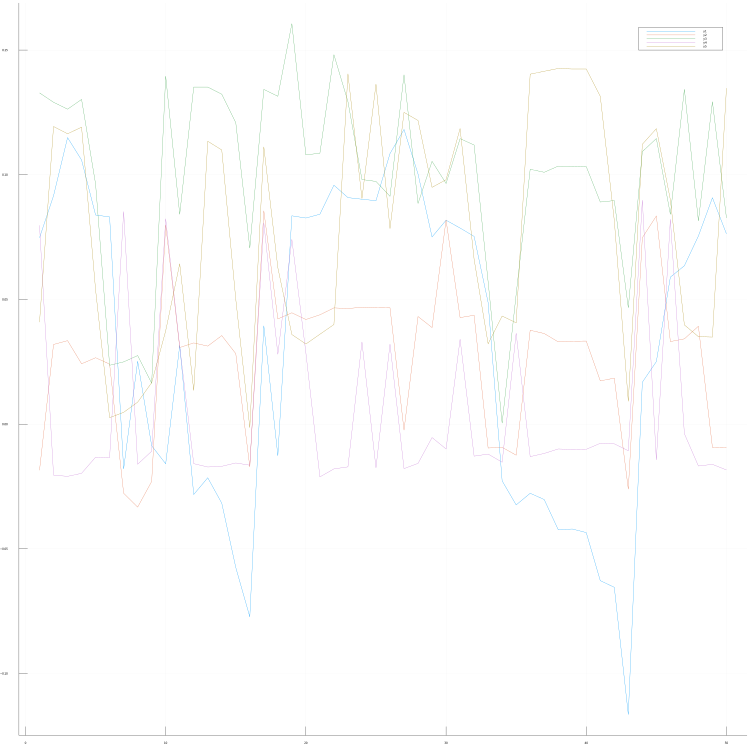

In [48]:
using Plots
plot(β_list[:,1:5])
plot!(size=(3000,3000))

# Old

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:])
                            - dot(λ_val0[2,:],y_val0) 
                            - dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            - dot(y.-y_val0,λ_val0[2,:]))
#     @constraint(model, γ >=   dot(λ_val0[2,:],y_val0) 
#                             + dot(λ[2,:].-λ_val0[2,:], y_val0) 
#                             + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α #- γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])
                                - dot(λ_val[2,:],y_val) 
                                - dot(λ[2,:].-λ_val[2,:], y_val) 
                                - dot(y.-y_val,λ_val[2,:]))
#             @constraint(model, γ >= dot(λ_val[2,:],y_val) 
#                             + dot(λ[2,:].-λ_val[2,:], y_val) 
#                             + dot(y.-y_val,λ_val[2,:]))
            println("Cut added")
        end
    end    
end

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = D_max #(D_min .+ D_max)./2
    L_OA, λ_val0, ν_val0, μ_val0 = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) + dot(λ[1,:].-λ_val0[1,:], y_val0) + dot(y.-y_val0,λ_val0[1,:]))
    
    # Add objective
    @objective(model, Max, 2*α - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
                                
            println("Cut added")
            println(y_val)
        end
    end    
end

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = D_max #(D_min .+ D_max)./2
    L_OA, λ_val0, ν_val0, μ_val0 = S_dual(X, y_val0, β0, epsilon, delta)
    
    # Add objective
    @objective(model, Max, 2*transpose(λ[1,:])*y - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
    end    
end

In [ ]:
n = 30
p = 5
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
epsilon = 0.05
delta = 0.05

D_min = Random.rand(n)
D_max = D_min .+ 0.5 
threshold = 0.5
β0 = Random.rand(p)
model, y, L_OA, U_OA, α, γ = U(X, D_min, D_max, β0, epsilon, delta, threshold)
println(U_OA)
println(L_OA)
y

In [ ]:
sub_OA = U_OA - getvalue.(α)

In [ ]:
sub_LA = L_OA - dot(λ_val[1,:],y_val) + dot(λ_val[2,:],y_val) 

In [ ]:
2*α - sum(y[t] for t=1:T)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T)

In [ ]:
dot(λ_val[1,:],y_val) - dot(λ_val[2,:],y_val)

In [ ]:
2*getvalue.(α)-sum(getvalue.(y))

In [ ]:
λ_val = getvalue.(λ)

In [ ]:
y_val = getvalue.(y)

In [ ]:
dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])

In [ ]:
dot(λ_val0[1,:],y_val0) + dot(λ_valu[1,:].-λ_val0[1,:], y_val0) + dot(y_val.-y_val0,λ_val0[1,:])

In [ ]:
dot(λ_valu[1,:],y_val) #+ dot(λ_valu[1,:].-λ_val0[1,:], y_val0) + dot(y_val.-y_val0,λ_val0[1,:])

In [ ]:
#First term S
s1 = dot(λ_val[1,:],y_val)
s1

In [ ]:
#Second term S
s2 = dot(λ_val[2,:],y_val)
s2

In [ ]:
#Total S
L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta);
print(L_OA)

In [ ]:
#Second part S
s3 = - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1) - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)+ sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
s3

In [ ]:
s1-s2+s3

In [ ]:
getvalue.(α)

In [ ]:
#First term U
u1 = 2*getvalue.(α) - sum(y_val);
u1

In [ ]:
s1-s2

In [ ]:
#Second term U
λ_valu, ν_valu, μ_valu = getvalue.(λ), getvalue.(ν),getvalue.(μ)
u3 = - delta * sum(sum(ν_valu[1,t,i]+ν_valu[2,t,i] for i=1:p) for t=1:T-1) - sum(dot(epsilon .+ β0, μ_valu[1,t,:]) for t = 1:T)+ sum(dot(epsilon .- β0, μ_valu[2,t,:]) for t = 1:T)
u3

# Work in progress

In [ ]:
function U(X, D_min, D_max, β0, epsilon, delta, threshold)
    
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
#         λ1_val = []
#         λ2_val = []
        
#         for t = 1:T
#             λ1_val = [λ1_val;callback_value(cb_data, λ[1,t])]
#             λ2_val = [λ2_val;callback_value(cb_data, λ[2,t])]
#         end
        
#         #linearization of the bilinear term
#         con1 = @build_constraint(α <= dot(λ1_val,y_val) 
#                                 + dot(λ[1,:].-λ1_val, y_val) 
#                                 + dot(y.-y_val,λ1_val))
#         con2 = @build_constraint(γ <= dot(λ2_val,y_val) 
#                             + dot(λ[2,:].-λ2_val, y_val) 
#                             + dot(y.-y_val,λ2_val))
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    #MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    #MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    
    optimize!(model)
    
    return model, getvalue.(y), L_OA, U_OA, getvalue.(α), getvalue.(γ)#get_objective_value(model)
end

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
#         λ1_val = []
#         λ2_val = []
        
#         for t = 1:T
#             λ1_val = [λ1_val;callback_value(cb_data, λ[1,t])]
#             λ2_val = [λ2_val;callback_value(cb_data, λ[2,t])]
#         end
        
#         #linearization of the bilinear term
#         con1 = @build_constraint(α <= dot(λ1_val,y_val) 
#                                 + dot(λ[1,:].-λ1_val, y_val) 
#                                 + dot(y.-y_val,λ1_val))
#         con2 = @build_constraint(γ <= dot(λ2_val,y_val) 
#                             + dot(λ[2,:].-λ2_val, y_val) 
#                             + dot(y.-y_val,λ2_val))
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    #MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    optimize!(model)
end

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    #MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    optimize!(model)
end

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, - γ >=   dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α + γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, "Upper: ", U_OA)
        cuts += 1
        U_OA = objective_value(model)
        y_val = getvalue.(y)
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        println(getvalue.(α))        
        if true#U_OA - L_OA > threshold
            con_α = @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
            con_γ = @constraint(model, γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
            #MOI.submit(model, con_α)
            #MOI.submit(model, con_γ)
            #model.AddConstr(con_α)
            optimize!(model)
            print("Cut added")
        end
    end    
end

In [ ]:
value.(model[:y])

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:])
                            - dot(λ_val0[2,:],y_val0) 
                            - dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            - dot(y.-y_val0,λ_val0[2,:]))
#     @constraint(model, γ >=   dot(λ_val0[2,:],y_val0) 
#                             + dot(λ[2,:].-λ_val0[2,:], y_val0) 
#                             + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α #- γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])
                                - dot(λ_val[2,:],y_val) 
                                - dot(λ[2,:].-λ_val[2,:], y_val) 
                                - dot(y.-y_val,λ_val[2,:]))
#             @constraint(model, γ >= dot(λ_val[2,:],y_val) 
#                             + dot(λ[2,:].-λ_val[2,:], y_val) 
#                             + dot(y.-y_val,λ_val[2,:]))
            println("Cut added")
        end
    end    
end

In [ ]:
println(getvalue.(α)) ; getvalue(γ)

In [ ]:
y_val = getvalue.(y)

In [ ]:
L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

In [ ]:
L_OA

In [ ]:
function solve_model(m)
    optimize!(m)
    U_OA = objective_value(m)
    println("U_OA from solve ", U_OA)
    return value.(m[:y]), U_OA
end

In [ ]:
model

In [ ]:
getvalue.(γ)

In [ ]:
optimize!(model)

In [ ]:
objective_value(model)

In [ ]:
n = 8
p = 4
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
epsilon = 0.05
delta = 0.05

D_min = Random.rand(n)
D_max = D_min .+ 0.5 
threshold = 0.5
β0 = Random.rand(p)
model, y, L_OA, U_OA, α, γ = U(X, D_min, D_max, β0, epsilon, delta, threshold)
println(U_OA)
println(L_OA)
y

In [ ]:
function inner_primal_infinity1(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))

    # Add variables
    @variable(model, a[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    @constraint(model,[i=1:n],- y[i] + dot(X[i,:],a[i,:]) <= b[i])
    @constraint(model,[i=1:n],  y[i] - dot(X[i,:],a[i,:]) <= b[i])

    @constraint(model,[i=2:n],   a[i,:] .- a[i-1,:] .<= delta)
    @constraint(model,[i=2:n], - a[i,:] .+ a[i-1,:] .<= delta)
    
    @constraint(model,[i=1:n],   a[i,:] .- β0 .<= epsilon)
    @constraint(model,[i=1:n], - a[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(a)
end

# Old

In [ ]:
function inner_primal_infinity2(X, y, β0, epsilon, delta)
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus[i=1:n],  - y[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus[i=1:n],  y[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(β)
end

In [ ]:
function inner_dual_infinity_shuvo(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .<= 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return model
end

In [ ]:
function inner_dual_infinity_shuvo2(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .<= 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return model
end

In [ ]:
m, beta = inner_primal_infinity2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

m, beta = inner_primal_infinity_2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

model = inner_dual_infinity_shuvo2(X,y,beta_0,epsilon,delta)
print("Obj value Dual:", objective_value(model))

In [ ]:
n = 30
p = 6
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
beta_0 = Random.rand(p)
beta_0[1] = - 0.3
epsilon = 0.1
delta = 0.1
#beta = inner_dual_infinity_leo_original_signs(X,y,beta_0,epsilon,delta)
#beta = inner_dual_infinity_leo(X,y,beta_0,epsilon,delta)



#model = inner_dual_infinity_leo(X,y,beta_0,epsilon,delta)
#print("Obj value Dual Leo:", objective_value(model))



#print("Primal 1", value(m.obj))

In [ ]:
m, beta = inner_primal_infinity1(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

m, beta = inner_primal_infinity2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

m, beta = inner_primal_infinity3(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

In [ ]:
Z = get_Z(X)
λ = Random.rand(n)

In [ ]:
function inner_dual_infinity_leo(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2,j=1:T]>=0) 
    @variable(model, ν[i=1:2, j=1:T,k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T,k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t=1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t=1:T)
        )
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
    @constraint(model,[t=1:T-1], X[t,:]*(λ[1,t]-λ[2,t]) .+ μ[2,t,:]-μ[1,t,:]
                                            .+ ν[2,t,:]-ν[1,t,:]
                                            .+ ν[2,t+1,:]-ν[1,t+1,:] .== 0)
    @constraint(model, X[T,:]*(λ[1,T]-λ[2,T]) .+ μ[2,T,:]-μ[1,T,:]
                                            .+ ν[2,T,:]-ν[1,T,:] .== 0)

    @constraint(model, [i=1:p], ν[1,1,i] == 0)
    @constraint(model, [i=1:p], ν[2,1,i] == 0)
    
    optimize!(model);
    
    return getvalue.(λ)
end

In [ ]:
function inner_dual_infinity_leo_original_signs(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2,j=1:T]<=0) 
    @variable(model, ν[i=1:2, j=1:T,k=1:p]<=0) 
    @variable(model, μ[i=1:2, j=1:T,k=1:p]<=0)

    # Add objective
    @objective(model, Max, dot(λ[2,:],y) - dot(λ[1,:],y) 
                            + delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T)
                            + sum(dot(epsilon .+ β0, μ[1,t,:]) for t=1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t=1:T)
        )
    
    @constraint(model,[t=1:T], -λ[1,:] .- λ[2,:] .== 1)
    @constraint(model,[t=1:T-1], X[t,:]*(λ[2,t]-λ[1,t]) .+ μ[1,t,:]-μ[2,t,:]
                                            .+ ν[1,t,:]-ν[2,t,:]
                                            .+ ν[1,t+1,:]-ν[2,t+1,:] .== 0)
    @constraint(model, X[T,:]*(λ[2,T]-λ[1,T]) .+ μ[1,T,:]-μ[2,T,:]
                                            .+ ν[1,T,:]-ν[2,T,:] .== 0)

    @constraint(model, [i=1:p], ν[1,1,i] == 0)
    @constraint(model, [i=1:p], ν[2,1,i] == 0)
    
    optimize!(model);
    
    return getvalue.(λ)
end

In [ ]:
n = 1
p = 1
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
beta_0 = Random.rand(p)
epsilon = 0.1
delta = 0.01
m, beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)
#print("Primal 1", value(m.obj))

In [ ]:
function inner_primal_infinity(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))

    # Add variables
    @variable(model, a[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    @constraint(model,[i=1:n],- y[i] + dot(X[i,:],a[i,:]) <= b[i])
    @constraint(model,[i=1:n],  y[i] - dot(X[i,:],a[i,:]) <= b[i])

    @constraint(model,[i=2:n],   a[i,:] .- a[i-1,:] .<= delta)
    @constraint(model,[i=2:n], - a[i,:] .+ a[i-1,:] .<= delta)
    
    @constraint(model,[i=1:n],   a[i,:] .- β0 .<= epsilon)
    @constraint(model,[i=1:n], - a[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(a)
end

In [ ]:
n = 3
p = 2
X = Array([[1., 2., 3.] [4., 5., 6.]])#Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Array([10.,11.,12.])#Random.rand(n)
beta_0 = Array([13.,14.])#Random.rand(p)
epsilon = 0.1
delta = 0.01
m, beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)
#print("Primal 1", value(m.obj))

In [ ]:
dual_model = dualize(m)

In [ ]:
beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)

In [ ]:
function l1_regression(X, y, rho)
    # number of observations
    n = nrow(X)
    # number of estimators
    m = ncol(X)
    
    # big M constant. Note big M should be small for l0 to work properly
    M = 25
    
    # convert input data frames to matrix/vector
    y_vector = convert(Matrix, y[:,:])
    X_matrix = convert(Matrix, X[:,:])
    
    # build model
    model = Model(with_optimizer(Gurobi.Optimizer))
    ##### Load Packagesset_optimizer_attribute(model, "OutputFlag", 0)
    # insert variables and constraints
    @variable(model,beta[i=1:m])
    @variable(model,z[i=1:m]>=0)
    @variable(model,u[i=1:n]>=0)
    @variable(model, sse>=0)
    @constraint(model,[i=1:m], beta[i]<=z[i])
    @constraint(model,[i=1:m], beta[i]>=-z[i])
    @constraint(model,[i=1:n],y_vector[i]-dot(X_matrix[i,:],beta)<=u[i])
    @constraint(model,[i=1:n],-y_vector[i]+dot(X_matrix[i,:],beta)<=u[i])
    @constraint(model, sum(u) <= sse)
    @objective(model,Min, sse + rho*sum(z[i] for i=1:m))
    
    # optimize
    optimize!(model);
    
    z_here = getvalue.(z)
    b_here = getvalue.(beta)
    # return estimated betas
    return (getvalue.(beta))
end